# Algo-trading: data preparation


> Author: <b>Nicola Bini</b>
>
> Date:   <b>06/17/2021</b>
>
>
> <b>Team 2:</b>
> <i>
> <br>Nicola Bini
> <br>Felipe Domingues
> <br>Tri Dung Dinh
> <br>Manuel Echazarra
> </i>

# Summary

Use signals generated previously by neural network to backtest the strategy on the training data

In [23]:
# Import libraries
import bt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [24]:
# Import ML signals

tickets = ["OCGN", "HGEN", "VUZI", "DNN"]
start_date = "2015-10-12"
end_date   = "2018-05-31"
train_data = bt.get(tickets, start=start_date, end=end_date)

train_signal_OCGN = pd.read_csv("train_signal_OCGN.csv")
train_signal_HGEN = pd.read_csv("train_signal_HGEN.csv")
train_signal_VUZI = pd.read_csv("train_signal_VUZI.csv")
train_signal_DNN  = pd.read_csv("train_signal_DNN.csv")

train_signal_OCGN['date'] = train_signal_OCGN['date'] .astype(np.datetime64)
train_signal_HGEN['date'] = train_signal_HGEN['date'] .astype(np.datetime64)
train_signal_VUZI['date'] = train_signal_VUZI['date'] .astype(np.datetime64)
train_signal_DNN['date']  = train_signal_DNN['date']  .astype(np.datetime64)

train_signal_OCGN = train_signal_OCGN.set_index("date")
train_signal_HGEN = train_signal_HGEN.set_index("date")
train_signal_VUZI = train_signal_VUZI.set_index("date")
train_signal_DNN  = train_signal_DNN.set_index("date")


In [25]:
signals = pd.concat([train_signal_OCGN, train_signal_HGEN, train_signal_VUZI, train_signal_DNN], axis=1)

In [26]:
signals

,OCGN,HGEN,VUZI,DNN
date,,,,
2015-10-12,0,1,0,0
2015-10-13,0,1,1,0
2015-10-14,1,0,0,0
2015-10-15,0,0,1,1
2015-10-16,1,0,1,1
...,...,...,...,...
2018-05-24,0,1,0,0
2018-05-25,0,1,1,0
2018-05-29,0,1,1,0


In [27]:
for col in signals:
    for i, row in signals.iterrows():
        if signals.loc[i, col] == 1:
            signals.loc[i, col] = -0.25
        elif signals.loc[i, col] == 0:
            signals.loc[i, col] = 0.25
        else:
            signals.loc[i, col] = "ERROR!!"
            
for col in signals:
    signals[col.lower()] = signals[col]
    signals.drop(col,axis=1, inplace=True)

In [38]:
signals.dtypes

ocgn    float64
hgen    float64
vuzi    float64
dnn     float64
dtype: object

In [48]:
ml_strategy = bt.Strategy('ml_strategy', [
                                          #bt.algos.SelectWhere(signals),
                                          bt.algos.WeighTarget(signals),
                                          bt.algos.Rebalance()])

benchmark   = bt.Strategy("benchmark_buy_hold",[bt.algos.RunWeekly(),
                                                bt.algos.SelectAll(),
                                                bt.algos.WeighEqually(),
                                                bt.algos.Rebalance()])

In [49]:
ml_backtest = bt.Backtest(ml_strategy, train_data)
benchmark_backtest = bt.Backtest(benchmark, train_data)
ml_res      = bt.run(ml_backtest,benchmark_backtest) # 

<AxesSubplot:title={'center':'Equity Progression'}>

<Figure size 432x288 with 0 Axes>

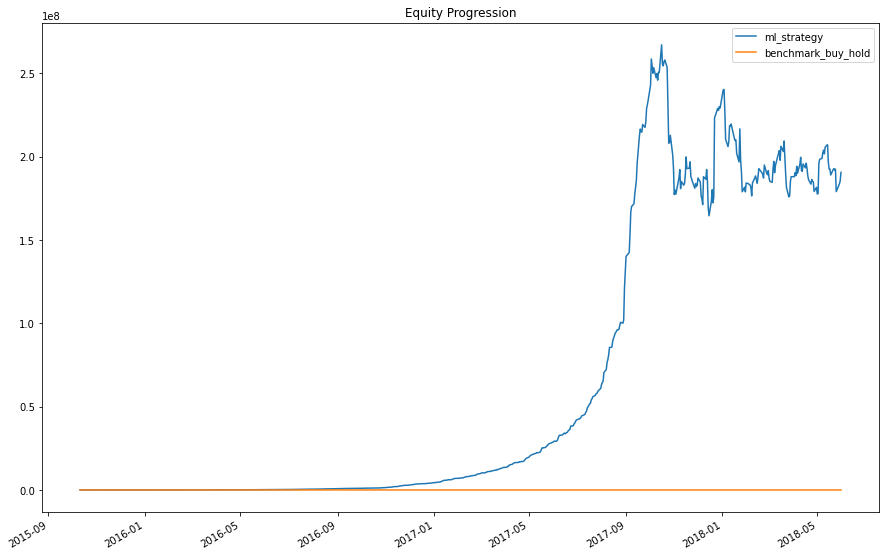

In [51]:
plt.figure()
#ml_res.plot(figsize=(15, 10),color='orange')
ml_res.plot(figsize=(15, 10))



Stat                 ml_strategy    benchmark_buy_hold
-------------------  -------------  --------------------
Start                2015-10-11     2015-10-11
End                  2018-05-31     2018-05-31
Risk-free rate       0.00%          0.00%

Total Return         190537346.93%  598.38%
Daily Sharpe         6.77           1.07
Daily Sortino        29.72          3.49
CAGR                 23993.11%      109.00%
Max Drawdown         -38.41%        -52.35%
Calmar Ratio         624.69         2.08

MTD                  4.93%          5.46%
3m                   -0.53%         -6.98%
6m                   4.21%          23.67%
YTD                  -16.85%        16.17%
1Y                   565.82%        30.39%
3Y (ann.)            23993.11%      109.00%
5Y (ann.)            -              -
10Y (ann.)           -              -
Since Incep. (ann.)  23993.11%      109.00%

Daily Sharpe         6.77           1.07
Daily Sortino        29.72          3.49
Daily Mean (ann.)    583.45%      

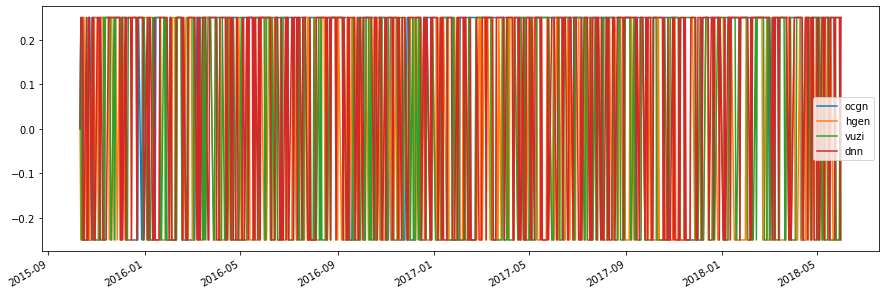

In [52]:
ml_res.display()
ml_res.plot_security_weights()